<a href="https://colab.research.google.com/github/tadashi404/final_project/blob/main/Garbage_Classification_by_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ตั้งค่า Kaggle API ใน Colab**

In [ ]:
# ติดตั้ง Kaggle CLI
!pip install -q kaggle

# สร้างโฟลเดอร์ .kaggle และคัดลอก key (อัปโหลด kaggle.json)
from google.colab import files

files.upload()  # อัปโหลดไฟล์ kaggle.json ที่ดาวน์โหลดจาก Kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**ดาวน์โหลด Dataset จาก Kaggle**

In [ ]:
# ดาวน์โหลด dataset จาก Kaggle
!kaggle datasets download -d mostafaabla/garbage-classification

# แตกไฟล์ zip
!unzip -q garbage-classification.zip -d garbage_dataset

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 66% 157M/239M [00:00<00:00, 1.63GB/s]
100% 239M/239M [00:00<00:00, 999MB/s] 


**แบ่ง dataset เป็น train / validation / test**

In [ ]:
!mkdir -p /content/.kaggle
!cp /content/kaggle.json /content/.kaggle/kaggle.json
!chmod 600 /content/.kaggle/kaggle.json

In [ ]:
# ================================================
# แบ่ง Dataset เป็น train / validation / test
# Kaggle: mostafaabla/garbage-classification
# ================================================
import os, shutil, zipfile, random
from pathlib import Path
from sklearn.model_selection import train_test_split

# ---------- พารามิเตอร์ ----------
EXTRACT_ROOT = Path("/content/garbage_raw")   # โฟลเดอร์ที่จะแตกไฟล์
SPLIT_BASE   = Path("/content/split_data")    # โฟลเดอร์ปลายทางของ train/val/test
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
random.seed(42)

# ---------- ถ้าไม่เจอไฟล์ ให้ดาวน์โหลดและแตกไฟล์อัตโนมัติ ----------
if not EXTRACT_ROOT.exists():
    print("ℹ️ ไม่พบโฟลเดอร์แตกไฟล์ จะติดตั้ง Kaggle CLI และดาวน์โหลดให้อัตโนมัติ")
    # ติดตั้ง kaggle และตั้งค่าโฟลเดอร์คีย์
    !pip -q install kaggle
    os.environ['KAGGLE_CONFIG_DIR'] = '/content/.kaggle'
    os.makedirs('/content/.kaggle', exist_ok=True)
    # ต้องอัปโหลด /content/.kaggle/kaggle.json มาก่อน (Files → Upload)
    if not os.path.exists('/content/.kaggle/kaggle.json'):
        raise RuntimeError("ไม่พบ /content/.kaggle/kaggle.json กรุณาอัปโหลด API key ของ Kaggle ก่อน")
    !chmod 600 /content/.kaggle/kaggle.json

    # ดาวน์โหลด
    zip_path = "/content/garbage-classification.zip"
    !kaggle datasets download -d mostafaabla/garbage-classification -p /content -q
    # แตกไฟล์
    EXTRACT_ROOT.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(EXTRACT_ROOT)
    print("✅ Download & Unzip เสร็จแล้วที่:", EXTRACT_ROOT)

# ---------- หาโฟลเดอร์ระดับคลาสอัตโนมัติ ----------
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}

def dir_has_images(p: Path) -> bool:
    return any(f.is_file() and f.suffix.lower() in IMG_EXTS for f in p.iterdir())

def is_class_root(p: Path, min_classes: int = 3) -> bool:
    if not p.is_dir():
        return False
    subdirs = [d for d in p.iterdir() if d.is_dir()]
    if len(subdirs) < min_classes:
        return False
    # ต้องมีอย่างน้อย min_classes โฟลเดอร์ที่มีรูป
    return sum(1 for d in subdirs if dir_has_images(d)) >= min_classes

def find_class_root(root: Path, max_depth: int = 4) -> Path | None:
    queue = [(root, 0)]
    visited = set()
    while queue:
        cur, depth = queue.pop(0)
        if cur in visited:
            continue
        visited.add(cur)
        if is_class_root(cur):
            return cur
        if depth < max_depth:
            for d in cur.iterdir():
                if d.is_dir():
                    queue.append((d, depth + 1))
    return None

class_root = find_class_root(EXTRACT_ROOT)

# เผื่อรูปแบบที่พบบ่อย
if class_root is None:
    cand1 = EXTRACT_ROOT / "Garbage classification"
    cand2 = EXTRACT_ROOT / "Garbage classification" / "Garbage classification"
    for c in (cand1, cand2):
        if is_class_root(c):
            class_root = c
            break

if class_root is None:
    raise RuntimeError(f"ไม่พบโฟลเดอร์ระดับคลาสภายใต้: {EXTRACT_ROOT}")

print("🗂️ พบ class root ที่:", class_root)
classes = sorted([d.name for d in class_root.iterdir() if d.is_dir() and dir_has_images(d)])
print("📚 Classes:", classes)

# ---------- เตรียมปลายทาง split ----------
train_dir = SPLIT_BASE / "train"
val_dir   = SPLIT_BASE / "val"
test_dir  = SPLIT_BASE / "test"
for d in (train_dir, val_dir, test_dir):
    d.mkdir(parents=True, exist_ok=True)

def copy_many(paths, dst_dir: Path):
    dst_dir.mkdir(parents=True, exist_ok=True)
    for src in paths:
        shutil.copy2(src, dst_dir / src.name)

# ---------- แบ่งต่อคลาส ----------
counts = {"train": 0, "val": 0, "test": 0}
for cls in classes:
    cls_dir = class_root / cls
    imgs = [p for p in cls_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    if not imgs:
        print(f"⚠️ ข้าม '{cls}' (ไม่พบรูป)")
        continue

    train_imgs, temp_imgs = train_test_split(imgs, test_size=(1 - train_ratio), random_state=42, shuffle=True)
    val_size = val_ratio / (val_ratio + test_ratio)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(1 - val_size), random_state=42, shuffle=True)

    copy_many(train_imgs, train_dir / cls)
    copy_many(val_imgs,   val_dir   / cls)
    copy_many(test_imgs,  test_dir  / cls)

    counts["train"] += len(train_imgs)
    counts["val"]   += len(val_imgs)
    counts["test"]  += len(test_imgs)

print("\n✅ แบ่งชุดข้อมูลเรียบร้อย")
print("📦 รวมจำนวนไฟล์:", counts)

# ---------- นับจำนวนไฟล์ต่อคลาส (สั้น ๆ) ----------
def count_per_class(base: Path):
    out = {}
    for d in sorted([p for p in base.iterdir() if p.is_dir()]):
        out[d.name] = sum(1 for f in d.iterdir() if f.is_file())
    return out

print("\n— Train per class —")
print(count_per_class(train_dir))
print("\n— Val per class —")
print(count_per_class(val_dir))
print("\n— Test per class —")
print(count_per_class(test_dir))

print("\n📁 โครงสร้างปลายทาง:", SPLIT_BASE)



ℹ️ ไม่พบโฟลเดอร์แตกไฟล์ จะติดตั้ง Kaggle CLI และดาวน์โหลดให้อัตโนมัติ
Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
✅ Download & Unzip เสร็จแล้วที่: /content/garbage_raw
🗂️ พบ class root ที่: /content/garbage_raw/garbage_classification
📚 Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

✅ แบ่งชุดข้อมูลเรียบร้อย
📦 รวมจำนวนไฟล์: {'train': 10853, 'val': 2329, 'test': 2333}

— Train per class —
{'battery': 661, 'biological': 689, 'brown-glass': 424, 'cardboard': 623, 'clothes': 3727, 'green-glass': 440, 'metal': 538, 'paper': 734, 'plastic': 605, 'shoes': 1383, 'trash': 487, 'white-glass': 542}

— Val per class —
{'battery': 142, 'biological': 148, 'brown-glass': 91, 'cardboard': 134, 'clothes': 799, 'green-glass': 94, 'metal': 115, 'paper': 158, 'plastic': 130, 'shoes': 297, 'trash': 105, 'white-glass': 116}

— Test per class —
{'batt

**โหลด Data**

🟢 Classes (12): ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
📦 Sizes — train: 10853, val: 2329, test: 2333


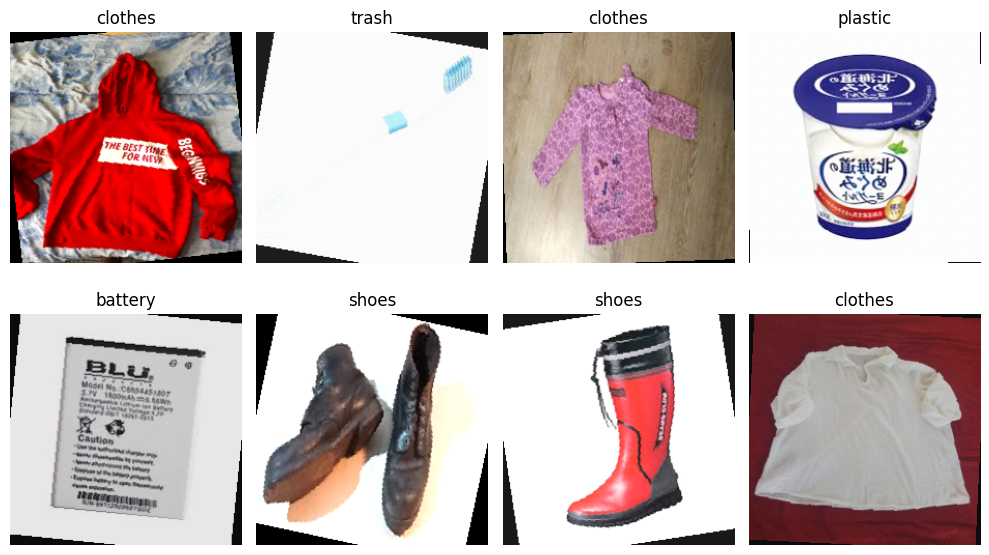

In [ ]:
# ============================
# DataLoader: train / val / test
# ============================
import os, sys
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

BASE_DIR = Path("/content/split_data")
assert (BASE_DIR/"train").exists() and (BASE_DIR/"val").exists() and (BASE_DIR/"test").exists(), \
    f"ไม่พบโฟลเดอร์ split_data ที่ {BASE_DIR} — กรุณารันสคริปต์แบ่ง dataset ก่อน"

# ---- Transforms ----
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# ---- Datasets ----
train_ds = datasets.ImageFolder(BASE_DIR/"train", transform=train_tfms)
val_ds   = datasets.ImageFolder(BASE_DIR/"val",   transform=eval_tfms)
test_ds  = datasets.ImageFolder(BASE_DIR/"test",  transform=eval_tfms)

# ---- DataLoaders ----
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

classes = train_ds.classes
print(f"🟢 Classes ({len(classes)}): {classes}")
print(f"📦 Sizes — train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

import matplotlib.pyplot as plt
import numpy as np

def denorm(img_t):
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    return (img_t*std+mean).clamp(0,1)

imgs, labels = next(iter(train_loader))
grid = imgs[:8]
plt.figure(figsize=(10,6))
for i in range(len(grid)):
    plt.subplot(2,4,i+1)
    plt.imshow(denorm(grid[i]).permute(1,2,0).cpu().numpy())
    plt.title(classes[labels[i]])
    plt.axis("off")
plt.tight_layout(); plt.show()

**สร้างโมเดล**

In [ ]:
# ============================
# Custom CNN for Garbage Classification
# ============================
import os, math, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ----- Fallback: สร้าง DataLoader อัตโนมัติถ้ายังไม่มี -----
try:
    train_loader
    classes = classes
except NameError:
    BASE_DIR = Path("/content/split_data")
    assert (BASE_DIR/"train").exists(), "ไม่พบ /content/split_data — กรุณารันขั้นแบ่ง dataset ก่อน"
    train_tfms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(12),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    eval_tfms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    train_ds = datasets.ImageFolder(BASE_DIR/"train", transform=train_tfms)
    val_ds   = datasets.ImageFolder(BASE_DIR/"val",   transform=eval_tfms)
    test_ds  = datasets.ImageFolder(BASE_DIR/"test",  transform=eval_tfms)

    classes = train_ds.classes
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🧠 Using device: {device}, classes={num_classes} -> {classes}")

# ----- โมเดล Custom CNN (ค่อนข้างเบา + BatchNorm + Dropout + AdaptivePool) -----
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, k=3, s=1, p=1, pool=True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(2) if pool else nn.Identity()
        self.drop = nn.Dropout2d(0.15)

    def forward(self, x):
        x = self.net(x)
        x = self.pool(x)
        return self.drop(x)

class CustomCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.block1 = ConvBlock(32,   64)    # 224 -> 112
        self.block2 = ConvBlock(64,  128)    # 112 -> 56
        self.block3 = ConvBlock(128, 256)    # 56  -> 28
        self.block4 = ConvBlock(256, 384)    # 28  -> 14
        self.block5 = ConvBlock(384, 512)    # 14  -> 7
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),         # 512 x 1 x 1
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return self.head(x)

model = CustomCNN(num_classes).to(device)

# ----- จัดการ class imbalance -----
def compute_class_weights(loader, n_classes):
    counts = torch.zeros(n_classes)
    for _, y in loader:
        for c in range(n_classes):
            counts[c] += (y == c).sum()
    weights = 1.0 / torch.clamp(counts, min=1.0)
    weights = weights / weights.sum() * n_classes
    return weights

use_class_weights = True
if use_class_weights:
    w = compute_class_weights(train_loader, num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=w)
    print("⚖️ class weights:", w.cpu().numpy())
else:
    criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# 🔧 ตัด verbose ออก และเตรียมฟังก์ชันอ่านค่า LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)
def get_lr(opt):
    return opt.param_groups[0]['lr']

scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


🧠 Using device: cuda, classes=12 -> ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
⚖️ class weights: [0.9572835  0.91838086 1.4923689  1.0156732  0.1697785  1.4381008
 1.176142   0.8620768  1.0458915  0.45753032 1.2993109  1.1674621 ]


/tmp/ipython-input-2319801790.py:126: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


**Train โมเดล**

In [ ]:
# ============================
# Train โมเดล (Fixed: ReduceLROnPlateau w/o verbose + LR logging)
# ============================
import torch, time, numpy as np
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(classes)

try:
    model
except NameError:
    class ConvBlock(nn.Module):
        def __init__(self, in_c, out_c, k=3, s=1, p=1, pool=True):
            super().__init__()
            self.net = nn.Sequential(
                nn.Conv2d(in_c, out_c, k, s, p, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, 1, 1, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            )
            self.pool = nn.MaxPool2d(2) if pool else nn.Identity()
            self.drop = nn.Dropout2d(0.15)
        def forward(self, x):
            x = self.net(x); x = self.pool(x); return self.drop(x)

    class CustomCNN(nn.Module):
        def __init__(self, n_classes):
            super().__init__()
            self.stem = nn.Sequential(
                nn.Conv2d(3, 32, 3, 1, 1, bias=False),
                nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            )
            self.block1 = ConvBlock(32, 64)
            self.block2 = ConvBlock(64, 128)
            self.block3 = ConvBlock(128, 256)
            self.block4 = ConvBlock(256, 384)
            self.block5 = ConvBlock(384, 512)
            self.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                nn.Dropout(0.3), nn.Linear(512, 256), nn.ReLU(inplace=True),
                nn.Dropout(0.3), nn.Linear(256, n_classes)
            )
        def forward(self, x):
            x = self.stem(x)
            x = self.block1(x); x = self.block2(x)
            x = self.block3(x); x = self.block4(x); x = self.block5(x)
            return self.head(x)

    model = CustomCNN(num_classes)

model = model.to(device)

# ----- class weights (เหมือนเดิม) -----
def compute_class_weights(loader, n_classes):
    counts = torch.zeros(n_classes)
    for _, y in loader:
        for c in range(n_classes):
            counts[c] += (y == c).sum()
    w = 1.0 / torch.clamp(counts, min=1.0)
    w = w / w.sum() * n_classes
    return w

use_class_weights = True
if use_class_weights:
    cls_w = compute_class_weights(train_loader, num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=cls_w)
    print("⚖️ class weights:", cls_w.cpu().numpy())
else:
    criterion = nn.CrossEntropyLoss()

# ----- Optimizer / Scheduler (ตัด verbose ออก) -----
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

def get_lr(opt):
    return opt.param_groups[0]['lr']

scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

# ----- Train / Eval loop -----
def run_epoch(loader, train_mode=True):
    model.train(mode=train_mode)
    total_loss, correct, n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        if train_mode:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        n += x.size(0)
    return total_loss / n, correct / n

EPOCHS = 30
patience = 4
best_val = 0.0
wait = 0
best_path = "/content/custom_cnn_best.pt"

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train_mode=True)
    val_loss, val_acc = run_epoch(val_loader, train_mode=False)

    # แสดงการลด LR ด้วยตัวเอง
    prev_lr = get_lr(optimizer)
    scheduler.step(val_loss)
    new_lr = get_lr(optimizer)
    lr_note = f" | LR ↓ {prev_lr:.2e}->{new_lr:.2e}" if new_lr != prev_lr else ""

    dt = time.time() - t0
    print(f"Epoch {epoch:02d} [{dt:.1f}s]  "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val  loss {val_loss:.4f} acc {val_acc:.4f}{lr_note}")

    # save best by val_acc
    if val_acc > best_val:
        best_val = val_acc
        torch.save({"model": model.state_dict(), "classes": classes}, best_path)
        print(f"  ✅ Save best ({best_val:.4f}) -> {best_path}")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break

# ----- ประเมินบน test -----
@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, correct, n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        n += x.size(0)
    return total_loss/n, correct/n

ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])

test_loss, test_acc = evaluate(test_loader)
print(f"\n🎯 Test  loss {test_loss:.4f}  acc {test_acc:.4f}")
print(f"📦 Best model saved at: {best_path}")


⚖️ class weights: [0.9572835  0.91838086 1.4923689  1.0156732  0.1697785  1.4381008
 1.176142   0.8620768  1.0458915  0.45753032 1.2993109  1.1674621 ]


/tmp/ipython-input-3163338579.py:82: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
/tmp/ipython-input-3163338579.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 01 [94.4s]  train loss 1.1980 acc 0.5968 | val  loss 1.1679 acc 0.6161
  ✅ Save best (0.6161) -> /content/custom_cnn_best.pt
Epoch 02 [93.4s]  train loss 1.1611 acc 0.6072 | val  loss 1.0289 acc 0.6702
  ✅ Save best (0.6702) -> /content/custom_cnn_best.pt
Epoch 03 [92.2s]  train loss 1.1473 acc 0.6211 | val  loss 1.0405 acc 0.6556
Epoch 04 [92.2s]  train loss 1.1294 acc 0.6219 | val  loss 0.9494 acc 0.6870
  ✅ Save best (0.6870) -> /content/custom_cnn_best.pt
Epoch 05 [93.2s]  train loss 1.1059 acc 0.6304 | val  loss 0.9984 acc 0.6595
Epoch 06 [92.6s]  train loss 1.0925 acc 0.6331 | val  loss 0.9913 acc 0.6677
Epoch 07 [92.1s]  train loss 1.0733 acc 0.6480 | val  loss 1.0374 acc 0.6578 | LR ↓ 3.00e-04->1.50e-04
Epoch 08 [92.5s]  train loss 0.9988 acc 0.6577 | val  loss 0.8512 acc 0.7201
  ✅ Save best (0.7201) -> /content/custom_cnn_best.pt
Epoch 09 [92.9s]  train loss 0.9887 acc 0.6625 | val  loss 0.8897 acc 0.7067
Epoch 10 [92.6s]  train loss 0.9708 acc 0.6734 | val  loss 0.8900

/tmp/ipython-input-3163338579.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):



🎯 Test  loss 0.6791  acc 0.7848
📦 Best model saved at: /content/custom_cnn_best.pt


**Evaluate และ Plot กราฟ**

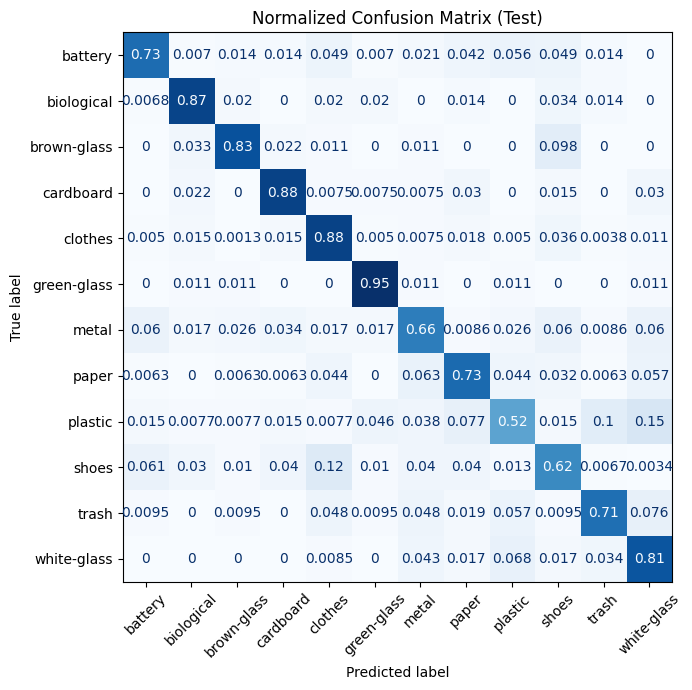

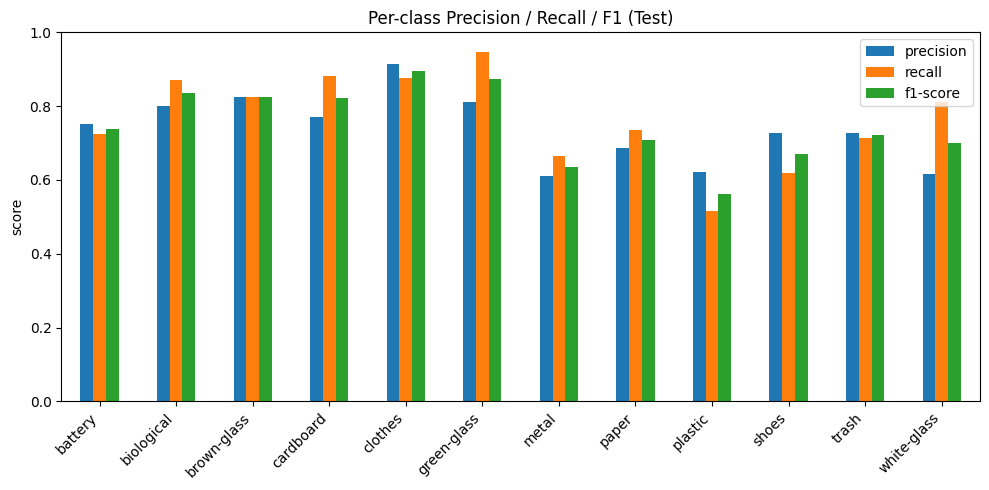

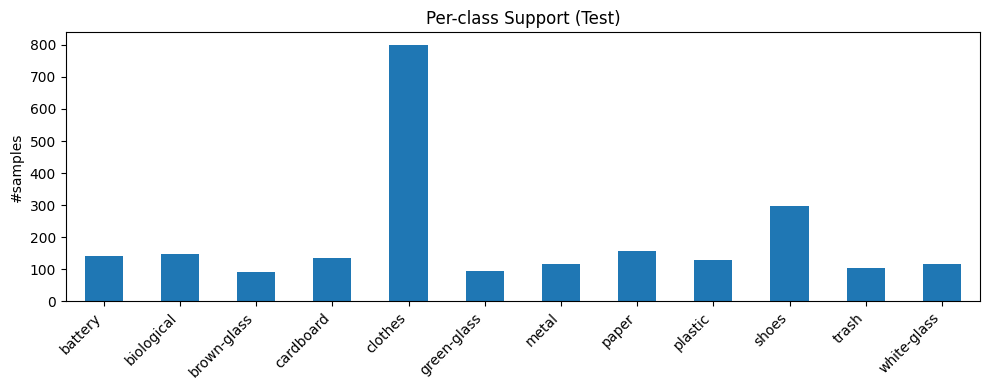

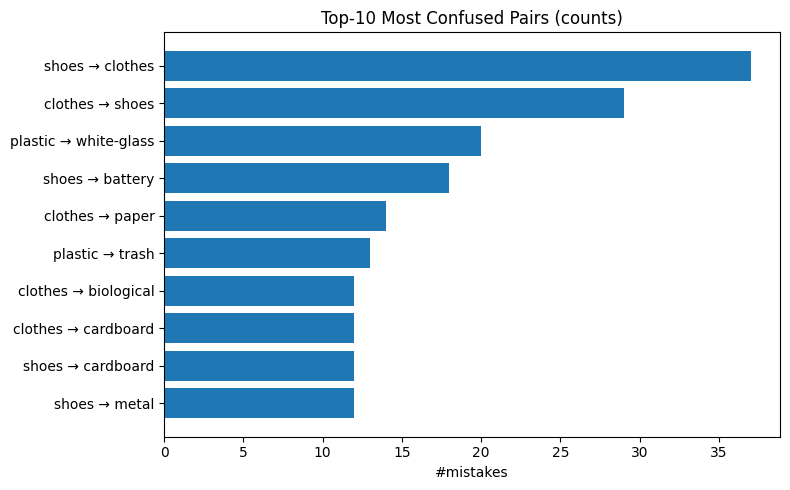

In [ ]:
# ---------- เพิ่มกราฟสรุปผลการทดสอบ ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# 1) Confusion matrix แบบ normalized (สัดส่วนต่อแถว)
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=classes,
    normalize='true',
    cmap='Blues',
    xticks_rotation=45,
    colorbar=False,
    ax=ax
)
ax.set_title("Normalized Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

# 2) ตารางค่าชี้วัดต่อคลาส แล้วทำกราฟ precision/recall/F1
rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df_rep = pd.DataFrame(rep).transpose()  # มีแถว micro/macro/weighted ด้วย
df_per_class = df_rep.loc[classes, ["precision","recall","f1-score"]]

ax = df_per_class.plot(kind="bar", figsize=(10,5))
ax.set_ylim(0, 1.0)
ax.set_title("Per-class Precision / Recall / F1 (Test)")
ax.set_ylabel("score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

# 3) กราฟจำนวนตัวอย่าง (support) ต่อคลาสในชุดทดสอบ
supports = df_rep.loc[classes, "support"]
ax = supports.plot(kind="bar", figsize=(10,4))
ax.set_title("Per-class Support (Test)")
ax.set_ylabel("#samples")
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

# 4) Top-10 most confused pairs (ดูว่าคลาสไหนมักพลาดเป็นคลาสอะไร)
cm_off = cm.copy().astype(int)
np.fill_diagonal(cm_off, 0)
pairs = []
for i in range(num_classes):
    for j in range(num_classes):
        if i != j and cm_off[i, j] > 0:
            pairs.append(((classes[i], classes[j]), int(cm_off[i, j])))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:10]

if pairs:
    labels = [f"{a} → {b}" for (a,b), _ in pairs]
    values = [v for _, v in pairs]
    fig, ax = plt.subplots(figsize=(8,5))
    ax.barh(labels[::-1], values[::-1])
    ax.set_title("Top-10 Most Confused Pairs (counts)")
    ax.set_xlabel("#mistakes")
    plt.tight_layout(); plt.show()
else:
    print("ไม่มีคู่ที่สับสนกันเลย (น่าจะทายถูกทุกคู่ใน test)")



**แยกประเภทของขยะตามถังขยะ 4 ประเภท**

In [ ]:
# ============================
# Mapping: fine-grained -> 4 ถัง
# ============================
# ชื่อคลาสในชุดนี้: ['battery','biological','brown-glass','cardboard','clothes',
#                     'green-glass','metal','paper','plastic','shoes','trash','white-glass']

BIN_HAZ   = "ขยะอันตราย"
BIN_GEN   = "ขยะทั่วไป"
BIN_REC   = "ขยะรีไซเคิล"
BIN_WET   = "ขยะเปียก"

# ตามที่ผู้ใช้ระบุ:
# อันตราย: แก้วต่างๆ, แบตเตอรี่, เหล็ก
# ทั่วไป: เสื้อผ้า, รองเท้า
# รีไซเคิล: กระดาษลัง, กระดาษ, พลาสติก
# เปียก: ขยะชีวภาพ, ขยะทั่วไป(ในที่นี้ตีความเป็น 'trash')
fine2bin = {
    "battery": BIN_HAZ,
    "brown-glass": BIN_HAZ,
    "green-glass": BIN_HAZ,
    "white-glass": BIN_HAZ,
    "metal": BIN_HAZ,

    "clothes": BIN_GEN,
    "shoes": BIN_GEN,
    "trash": BIN_GEN,

    "cardboard": BIN_REC,
    "paper": BIN_REC,
    "plastic": BIN_REC,

    "biological": BIN_WET,
}

# สำหรับบ้างกรณีที่ classes เรียงไม่เหมือนตัวอย่าง ให้สร้าง index map
cls2idx = {c:i for i,c in enumerate(classes)}

# รวมรายชื่อคลาสของแต่ละถังเผื่อโชว์
bin2classes = {
    BIN_HAZ: ["battery","brown-glass","green-glass","white-glass","metal"],
    BIN_GEN: ["clothes","shoes"],
    BIN_REC: ["cardboard","paper","plastic"],
    BIN_WET: ["biological","trash"],
}

# ============================
# Predict function (คืนคลาส/ถัง + top5 + สรุปคะแนนรายถัง)
# ============================
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont

@torch.no_grad()
def predict_image_with_bin(pil_img, tta=0):
    # ทำ inference แบบเดียวกับ val/test
    def _forward(pil):
        x = eval_tfms(pil).unsqueeze(0).to(device)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            return model(x).squeeze(0).float()

    logits = _forward(pil_img)
    if tta and tta > 0:
        aug = [logits, _forward(pil_img.transpose(Image.FLIP_LEFT_RIGHT))]
        logits = torch.stack(aug).mean(0)

    probs = torch.softmax(logits, dim=0).cpu().numpy()

    # top-5 รายคลาส
    top5_idx = probs.argsort()[-5:][::-1]
    top5 = [(classes[i], float(probs[i])) for i in top5_idx]

    # คลาสทายหลัก
    pred_cls_idx = int(np.argmax(probs))
    pred_cls = classes[pred_cls_idx]
    pred_cls_conf = float(probs[pred_cls_idx])

    # รวมคะแนนราย "ถัง" (sum ของ probs ของคลาสที่อยู่ในถังนั้น)
    bin_scores = {BIN_HAZ:0.0, BIN_GEN:0.0, BIN_REC:0.0, BIN_WET:0.0}
    for cls_name, p in zip(classes, probs):
        b = fine2bin.get(cls_name, BIN_GEN)  # ถ้าไม่พบ mapping ให้โยนเข้าทั่วไป
        bin_scores[b] += float(p)

    # เลือกถังที่คะแนนรวมมากสุด
    pred_bin = max(bin_scores.items(), key=lambda kv: kv[1])[0]
    pred_bin_conf = bin_scores[pred_bin]

    return {
        "pred_class": (pred_cls, pred_cls_conf),
        "top5": top5,
        "bin_scores": bin_scores,
        "pred_bin": (pred_bin, pred_bin_conf),
    }

def annotate_and_save_with_bin(pil_img, pred_cls, pred_cls_conf, pred_bin, pred_bin_conf, save_path):
    # แสดงทั้ง ถัง และ คลาส
    img = pil_img.convert("RGB").copy()
    draw = ImageDraw.Draw(img)
    line1 = f"{pred_bin} ({pred_bin_conf*100:.1f}%)"
    line2 = f"{pred_cls} ({pred_cls_conf*100:.1f}%)"
    w, h = img.size
    pad = 6
    bar_h = 58  # สองบรรทัด
    draw.rectangle([0, 0, w, bar_h], fill=(0,0,0))
    try:
        font = ImageFont.load_default()
    except:
        font = None
    draw.text((pad, 6),  line1, fill=(255,255,255), font=font)
    draw.text((pad, 30), line2, fill=(200,200,200), font=font)
    img.save(save_path)
    return save_path

**ทดสอบกับภาพจริง**

เลือกไฟล์ภาพเพื่ออัปโหลด…


Saving 12.webp to 12 (3).webp

📄 12 (3).webp
🗑️ ถังที่แนะนำ: ขยะอันตราย  (76.52%)
🔎 คลาสที่ทาย: battery (67.57%)
Top-5 คลาส:
  -      battery : 67.57%
  -   biological : 17.95%
  -        metal :  6.60%
  -        shoes :  4.06%
  -  brown-glass :  2.26%

คะแนนรวมรายถัง:
  -   ขยะอันตราย : 76.52%
  -    ขยะทั่วไป :  4.14%
  -  ขยะรีไซเคิล :  1.39%
  -     ขยะเปียก : 17.95%


/tmp/ipython-input-1794378139.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


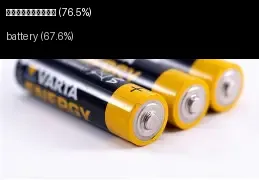

In [ ]:
from google.colab import files
import io, os
from IPython.display import display
from PIL import Image

print("เลือกไฟล์ภาพเพื่ออัปโหลด…")
uploaded = files.upload()
os.makedirs("/content/infer_out", exist_ok=True)

for fname in uploaded.keys():
    pil = Image.open(io.BytesIO(uploaded[fname])).convert("RGB")
    out = predict_image_with_bin(pil, tta=2)  # เปิด TTA เบาๆ

    pred_cls, pred_cls_conf = out["pred_class"]
    pred_bin, pred_bin_conf = out["pred_bin"]

    out_path = f"/content/infer_out/pred_{os.path.basename(fname)}"
    annotate_and_save_with_bin(pil, pred_cls, pred_cls_conf, pred_bin, pred_bin_conf, out_path)

    # สรุปผล
    print(f"\n📄 {fname}")
    print(f"🗑️ ถังที่แนะนำ: {pred_bin}  ({pred_bin_conf*100:.2f}%)")
    print(f"🔎 คลาสที่ทาย: {pred_cls} ({pred_cls_conf*100:.2f}%)")
    print("Top-5 คลาส:")
    for cls, p in out["top5"]:
        print(f"  - {cls:>12s} : {p*100:5.2f}%")

    print("\nคะแนนรวมรายถัง:")
    for b, s in out["bin_scores"].items():
        print(f"  - {b:>12s} : {s*100:5.2f}%")

    display(Image.open(out_path))
